# Q1

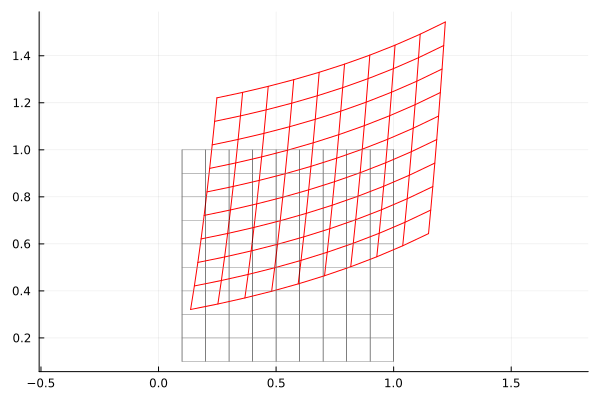

In [15]:

using Plots

X1 = range(0.1, 1, length=10)
X2 = range(0.1, 1, length=10)

X1g = [x for y in X2, x in X1]
X2g = [y for y in X2, x in X1]

u1 = 0.2 .* log.(1 .+ X1g .+ X2g)
u2 = 0.2 .* exp.(X1g)

x1 = X1g .+ u1
x2 = X2g .+ u2

p = plot(aspect_ratio=:equal, legend=false)

for j in axes(X1g,2)
    plot!(X1g[:,j], X2g[:,j], color=:black, lw=0.5)
    plot!(x1[:,j], x2[:,j], color=:red)
end

for i in axes(X1g,1)
    plot!(X1g[i,:], X2g[i,:], color=:gray, lw=0.5)
    plot!(x1[i,:], x2[i,:], color=:red)
end

display(p)

# Q2

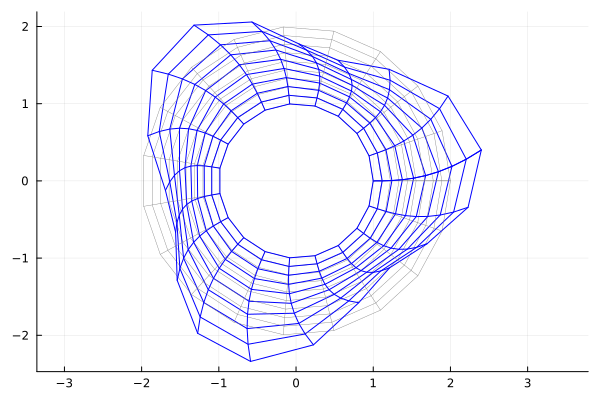

In [19]:

using Plots

R = range(1, 2, length=10)
θ = range(0, 2π, length=20)

Rg = [r for θi in θ, r in R]
Θg = [θi for θi in θ, r in R]

ur = 0.4 .* (Rg .- 1).^2 .* cos.(3 .* Θg)
uθ = 0.4 .* (Rg .- 1).^3

# convert (R,θ) to Cartesian before + after
aX = Rg .* cos.(Θg)
aY = Rg .* sin.(Θg)

bX = (Rg .+ ur) .* cos.(Θg) .- (uθ) .* sin.(Θg)
bY = (Rg .+ ur) .* sin.(Θg) .+ (uθ) .* cos.(Θg)

p = plot(aspect_ratio=:equal, legend=false)

for j in axes(aX,2)
    plot!(aX[:,j], aY[:,j], color=:gray, lw=0.4)
    plot!(bX[:,j], bY[:,j], color=:blue)
end
for i in axes(aX,1)
    plot!(aX[i,:], aY[i,:], color=:gray, lw=0.4)
    plot!(bX[i,:], bY[i,:], color=:blue)
end

display(p)


# Q3

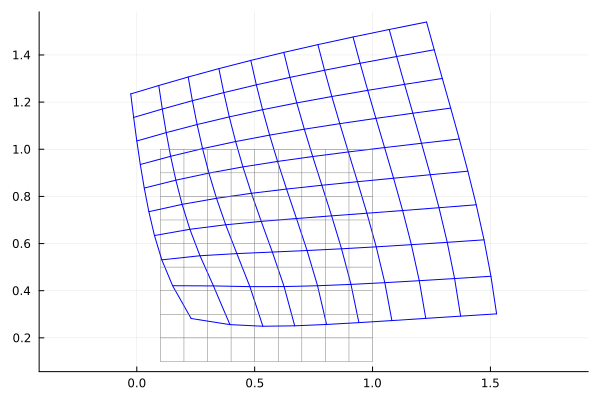

In [20]:

using Plots

X1 = range(0.1, 1, length=10)
X2 = range(0.1, 1, length=10)

X1g = [x for y in X2, x in X1]
X2g = [y for y in X2, x in X1]

ur = 0.2 .* exp.(X1g)
uθ = 0.2 .* log.(1 .+ X1g .+ X2g)

# Convert rectangular (X1,X2) → polar (R,θ)
R = sqrt.(X1g.^2 .+ X2g.^2)
θ = atan.(X2g, X1g)

erx = cos.(θ);  ery = sin.(θ)
eθx = -sin.(θ); eθy = cos.(θ)

uX = ur .* erx .+ uθ .* eθx
uY = ur .* ery .+ uθ .* eθy

x1 = X1g .+ uX
x2 = X2g .+ uY

p = plot(aspect_ratio=:equal, legend=false)
for j in axes(X1g,2)
    plot!(X1g[:,j], X2g[:,j], color=:gray, lw=0.5)
    plot!(x1[:,j], x2[:,j], color=:blue)
end
for i in axes(X1g,1)
    plot!(X1g[i,:], X2g[i,:], color=:gray, lw=0.5)
    plot!(x1[i,:], x2[i,:], color=:blue)
end

display(p)

# Q4

In [29]:
import Gmsh
using Gmsh: gmsh

gmsh.initialize()
gmsh.model.add("plate_hole")

Lx = 1000.0
Ly = 400.0
cx = Lx/2
cy = Ly/2
R  = 75.0

# ------------------------------------------
# Rectangle geometry
# ------------------------------------------
p1 = gmsh.model.geo.addPoint(0,   0, 0, 20)
p2 = gmsh.model.geo.addPoint(Lx,  0, 0, 20)
p3 = gmsh.model.geo.addPoint(Lx, Ly, 0, 20)
p4 = gmsh.model.geo.addPoint(0,  Ly, 0, 20)

l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

cl1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

# ------------------------------------------
# Hole (circle boundary)
# ------------------------------------------
npts = 64
circle_pts = Int[]

for i in 1:npts
    θ = 2π*(i-1)/npts
    px = cx + R*cos(θ)
    py = cy + R*sin(θ)
    push!(circle_pts, gmsh.model.geo.addPoint(px, py, 0, 3.0))  # fine mesh around hole
end

# Center point for circle arcs
pc = gmsh.model.geo.addPoint(cx, cy, 0, 3.0)

arcs = Int[]
for i in 1:npts
    a = circle_pts[i]
    b = circle_pts[(i % npts) + 1]
    push!(arcs, gmsh.model.geo.addCircleArc(a, pc, b))
end

cl2 = gmsh.model.geo.addCurveLoop(arcs)

# ------------------------------------------
# Plane surface = rectangle minus hole
# ------------------------------------------
sf = gmsh.model.geo.addPlaneSurface([cl1, cl2])

# Now the surface exists → NOW we can assign physical groups
gmsh.model.addPhysicalGroup(2, [sf], 10, "Domain")

# Boundaries
gmsh.model.addPhysicalGroup(1, [l1], 1, "Bottom")
gmsh.model.addPhysicalGroup(1, [l2], 2, "Right")
gmsh.model.addPhysicalGroup(1, [l3], 3, "Top")
gmsh.model.addPhysicalGroup(1, [l4], 4, "Left")

# Hole boundary
gmsh.model.addPhysicalGroup(1, arcs, 5, "Hole")

# ------------------------------------------
# Mesh + output
# ------------------------------------------
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.fltk.run()   # show mesh on screen

gmsh.write("plate_hole.msh")
gmsh.finalize()

labeling = get_face_labeling(model)
for (tag, name) in labeling.tag_to_name
    println("  Tag $tag: '$name'")
end
println("mesh saved as plate_hole.msh")


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Circle)
Info    : [ 10%] Meshing curve 6 (Circle)
Info    : [ 10%] Meshing curve 7 (Circle)
Info    : [ 20%] Meshing curve 8 (Circle)
Info    : [ 20%] Meshing curve 9 (Circle)
Info    : [ 20%] Meshing curve 10 (Circle)
Info    : [ 20%] Meshing curve 11 (Circle)
Info    : [ 20%] Meshing curve 12 (Circle)
Info    : [ 20%] Meshing curve 13 (Circle)
Info    : [ 20%] Meshing curve 14 (Circle)
Info    : [ 30%] Meshing curve 15 (Circle)
Info    : [ 30%] Meshing curve 16 (Circle)
Info    : [ 30%] Meshing curve 17 (Circle)
Info    : [ 30%] Meshing curve 18 (Circle)
Info    : [ 30%] Meshing curve 19 (Circle)
Info    : [ 30%] Meshing curve 20 (Circle)
Info    : [ 30%] Meshing curve 21 (Circle)
Info    : [ 40%] Meshing curve 22 (Circle)
Info    : [ 40%] Meshing curve 23 (Circle)
Info

In [1]:
# solve_plate_hole_with_tags.jl
using Gridap
using GridapGmsh
using LinearAlgebra
using WriteVTK
using Printf
using StaticArrays
# ---------------------------
# Mesh file (change path if needed)
# ---------------------------
meshfile = "plate_hole.msh"   # make sure this file is in the working directory
println("Loading mesh: $meshfile")
model = GmshDiscreteModel(meshfile)

# ---------------------------
# Print face labeling (confirm tags -> names)
# ---------------------------
println("\nPhysical groups (face labeling):")
labeling = get_face_labeling(model)
for (tag, name) in labeling.tag_to_name
    println("  Tag $tag: '$name'")
end

# ---------------------------
# Use the known tag numbers (from your Gmsh run)
# ---------------------------
left_tag   = 4   # "Left" boundary
right_tag  = 2   # "Right" boundary
bottom_tag = 1   # "Bottom" boundary
top_tag    = 3   # "Top" boundary
hole_tag   = 5   # "Hole" boundary (if needed)
domain_tag = 10  # "Domain" surface

println("\nUsing boundary tags:")
println("  Left:   $left_tag")
println("  Right:  $right_tag")
println("  Bottom: $bottom_tag")
println("  Top:    $top_tag")
println("  Hole:   $hole_tag")
println("  Domain: $domain_tag")

# ---------------------------
# Material & constitutive (plane-stress)
# ---------------------------
E = 210000.0   # N/mm^2
ν = 0.3

C = (E/(1-ν^2)) * [
    1.0   ν     0.0
    ν     1.0   0.0
    0.0   0.0  (1-ν)/2
]

function stress_tensor(∇u)
    ε = 0.5 * (∇u + ∇u')
    exx = ε[1,1]; eyy = ε[2,2]
    eng_shear = ε[1,2] + ε[2,1]   # engineering shear = 2*ε12_sym
    sv = C * @SVector [exx, eyy, eng_shear]
    sxx, syy, tau_eng = sv
    return TensorValue(sxx, tau_eng/2, tau_eng/2, syy)
end

# ---------------------------
# FE spaces (split so we constrain only u_x on left)
# ---------------------------
order = 1
reffe = ReferenceFE(lagrangian, Float64, order)

# Dirichlet: u_x = 0 on Left (use tag number)
Vx = FESpace(model, reffe; conformity=:H1, dirichlet_tags=[left_tag])

# To prevent vertical rigid motion, pin a single node (choose a node on bottom-left)
all_nodes = get_nodes(model)
# choose the node with minimum x+y as a robust "corner" pick
p_fix = first(keys(all_nodes))
minval = sum(all_nodes[p_fix])
for (nid, coords) in all_nodes
    if sum(coords) < minval
        p_fix = nid
        minval = sum(coords)
    end
end
println("\nPinning node id $p_fix (coords = $(all_nodes[p_fix])) to remove rigid vertical dof.")

Vy = FESpace(model, reffe; conformity=:H1, dirichlet_nodes=[p_fix])

V = MultiFieldFESpace([Vx, Vy])
U = TrialFESpace(V)
T = TestFESpace(V)

# ---------------------------
# Weak form
# ---------------------------
function a(u, v)
    σ = stress_tensor(∇(u))
    inner(σ, 0.5*(∇(v) + ∇(v)'))
end

trian = Triangulation(model)
quad = CellQuadrature(trian, 2)
op = AffineFEOperator(U, T, trian, quad, a, (v)->zero(v))

# ---------------------------
# Neumann: traction on Right (use tag number)
# ---------------------------
traction = VectorValue(100.0, 0.0)  # N/mm (per unit thickness)
ΓR = BoundaryTriangulation(model, tags=[right_tag])
quadR = FaceQuadrature(ΓR, 2)

# Assemble Neumann term
assemble!(op, (v)-> ∫(x-> dot(traction, v(x))) * ΓR * quadR)
println("Applied traction on Right boundary (tag $right_tag).")

# ---------------------------
# Solve
# ---------------------------
println("\nAssembling and solving linear system...")
uh = solve(op)

ux = uh[1]
uy = uh[2]

# ---------------------------
# Stress projection and von Mises
# ---------------------------
trianV = Triangulation(model)
quadV = CellQuadrature(trianV, 2)

σspace = FESpace(model, ReferenceFE(lagrangian, TensorValue{2,2,Float64}, 1); conformity=:L2)
σproj = L2Projection(σspace, trianV, quadV) do x
    stress_tensor(∇(uh)(x))
end
σh = solve(σproj)

vmspace = FESpace(model, ReferenceFE(lagrangian, Float64, 1); conformity=:L2)
vmproj = L2Projection(vmspace, trianV, quadV) do x
    σ = σh(x)
    sxx = σ[1,1]; syy = σ[2,2]; sxy = σ[1,2]
    sqrt(sxx^2 - sxx*syy + syy^2 + 3*sxy^2)
end
vmh = solve(vmproj)

# ---------------------------
# Postprocessing: maxima
# ---------------------------
maxUx = maximum(pointwise(ux))
maxUy = maximum(pointwise(uy))
maxVM = maximum(pointwise(vmh))

# displacement magnitude sampled over quadrature
maxDisp = 0.0
for cell in trian
    for (ξ, w) in get_cell_quadrature(cell, 2)
        x = map_to_physical(cell, ξ)
        d = sqrt(ux(x)^2 + uy(x)^2)
        maxDisp = max(maxDisp, d)
    end
end

println("\n---------------- RESULTS ----------------")
@printf("Max displacement magnitude (mm): %12.6e\n", maxDisp)
@printf("Max von Mises stress (MPa):      %12.6e\n", maxVM)
@printf("Max Ux:                           %12.6e\n", maxUx)
@printf("Max Uy:                           %12.6e\n", maxUy)
println("-----------------------------------------")

# ---------------------------
# Export to VTK for ParaView
# ---------------------------
writevtk(trianV, "plate_hole_results",
    cellfields = ["sigma" => σh, "von_mises" => vmh],
    pointfields = ["ux" => ux, "uy" => uy]
)
println("VTK written: plate_hole_results.vtu")
println("Open with ParaView to visualize displacements and von Mises stress.")





Loading mesh: plate_hole.msh
Info    : Reading 'plate_hole.msh'...
Info    : 138 entities
Info    : 3441 nodes
Info    : 6882 elements
Info    : Done reading 'plate_hole.msh'

Physical groups (face labeling):
  Tag B: 'o'
  Tag R: 'i'
  Tag T: 'o'
  Tag L: 'e'
  Tag H: 'o'
  Tag D: 'o'

Using boundary tags:
  Left:   4
  Right:  2
  Bottom: 1
  Top:    3
  Hole:   5
  Domain: 10


LoadError: UndefVarError: `get_nodes` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Q5

In [48]:
using Gmsh

function generate_cantilever_beam_mesh_3d()
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("cantilever_beam_3d")
    
    # Beam dimensions from the image (mm)
    L = 1000.0    # Length (1000 mm)
    W = 250.0     # Width (250 mm - rectangular cross-section)
    H = 200.0     # Height (200 mm - rectangular cross-section)
    
    # Mesh parameters
    mesh_size_coarse = 50.0   # Coarse mesh
    mesh_size_fine = 20.0     # Fine mesh near loaded end
    
    println("Generating 3D cantilever beam mesh:")
    println("  Length: $L mm")
    println("  Width: $W mm")
    println("  Height: $H mm")
    
    # Create points for the rectangular beam
    # Fixed end (z=0 plane)
    p1 = gmsh.model.geo.addPoint(0, 0, 0, mesh_size_coarse)      # Bottom-left-front
    p2 = gmsh.model.geo.addPoint(W, 0, 0, mesh_size_coarse)      # Bottom-right-front  
    p3 = gmsh.model.geo.addPoint(W, H, 0, mesh_size_coarse)      # Top-right-front
    p4 = gmsh.model.geo.addPoint(0, H, 0, mesh_size_coarse)      # Top-left-front
    
    # Free end (z=L plane)
    p5 = gmsh.model.geo.addPoint(0, 0, L, mesh_size_fine)        # Bottom-left-back
    p6 = gmsh.model.geo.addPoint(W, 0, L, mesh_size_fine)        # Bottom-right-back
    p7 = gmsh.model.geo.addPoint(W, H, L, mesh_size_fine)        # Top-right-back
    p8 = gmsh.model.geo.addPoint(0, H, L, mesh_size_fine)        # Top-left-back
    
    # Create edges
    # Fixed face edges (z=0)
    l1 = gmsh.model.geo.addLine(p1, p2)   # Bottom edge
    l2 = gmsh.model.geo.addLine(p2, p3)   # Right edge  
    l3 = gmsh.model.geo.addLine(p3, p4)   # Top edge
    l4 = gmsh.model.geo.addLine(p4, p1)   # Left edge
    
    # Free face edges (z=L)
    l5 = gmsh.model.geo.addLine(p5, p6)   # Bottom edge
    l6 = gmsh.model.geo.addLine(p6, p7)   # Right edge
    l7 = gmsh.model.geo.addLine(p7, p8)   # Top edge
    l8 = gmsh.model.geo.addLine(p8, p5)   # Left edge
    
    # Longitudinal edges
    l9 = gmsh.model.geo.addLine(p1, p5)    # Bottom-left
    l10 = gmsh.model.geo.addLine(p2, p6)   # Bottom-right
    l11 = gmsh.model.geo.addLine(p3, p7)   # Top-right
    l12 = gmsh.model.geo.addLine(p4, p8)   # Top-left
    
    # Create surfaces
    # Fixed face (z=0) - where beam is clamped
    cl1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
    s1 = gmsh.model.geo.addPlaneSurface([cl1])
    
    # Free face (z=L) - where load is applied
    cl2 = gmsh.model.geo.addCurveLoop([l5, l6, l7, l8])
    s2 = gmsh.model.geo.addPlaneSurface([cl2])
    
    # Side faces
    cl3 = gmsh.model.geo.addCurveLoop([l1, l10, -l5, -l9])    # Bottom face
    s3 = gmsh.model.geo.addPlaneSurface([cl3])
    
    cl4 = gmsh.model.geo.addCurveLoop([l2, l11, -l6, -l10])   # Right face
    s4 = gmsh.model.geo.addPlaneSurface([cl4])
    
    cl5 = gmsh.model.geo.addCurveLoop([l3, l12, -l7, -l11])   # Top face
    s5 = gmsh.model.geo.addPlaneSurface([cl5])
    
    cl6 = gmsh.model.geo.addCurveLoop([l4, l9, -l8, -l12])    # Left face
    s6 = gmsh.model.geo.addPlaneSurface([cl6])
    
    # Create volume
    sl1 = gmsh.model.geo.addSurfaceLoop([s1, s2, s3, s4, s5, s6])
    vol1 = gmsh.model.geo.addVolume([sl1])
    
    # Synchronize
    gmsh.model.geo.synchronize()
    
    # Define physical groups for FEA
    # Fixed end (where beam is clamped)
    gmsh.model.addPhysicalGroup(2, [s1], 1, "FixedEnd")
    
    # Free end (where load is applied)
    gmsh.model.addPhysicalGroup(2, [s2], 2, "FreeEnd")
    
    # Top surface (where point load acts in the image)
    gmsh.model.addPhysicalGroup(2, [s5], 3, "TopSurface")
    
    # Other surfaces
    gmsh.model.addPhysicalGroup(2, [s3], 4, "BottomSurface")
    gmsh.model.addPhysicalGroup(2, [s4], 5, "RightSurface") 
    gmsh.model.addPhysicalGroup(2, [s6], 6, "LeftSurface")
    
    # Volume
    gmsh.model.addPhysicalGroup(3, [vol1], 10, "BeamVolume")
    
    # Generate 3D mesh
    gmsh.model.mesh.generate(3)
    
    # Set mesh algorithm for better quality
    gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal
    gmsh.option.setNumber("Mesh.Algorithm3D", 1)  # Delaunay
    
    # Optimize mesh
    gmsh.model.mesh.optimize("Netgen")
    
    # Save mesh
    gmsh.write("cantilever_beam_3d.msh")
    
    println("\n3D mesh generation complete!")
    println("Mesh saved as: cantilever_beam_3d.msh")
    
    # Show mesh
    gmsh.fltk.run()
    
    gmsh.finalize()
end

# Run the function
generate_cantilever_beam_mesh_3d()

Generating 3D cantilever beam mesh:
  Length: 1000.0 mm
  Width: 250.0 mm
  Height: 200.0 mm
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00562406s, CPU 0s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] M